### Import Library

In [1]:
# pytorch libraries
import torch, torchvision
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from PIL import Image

# Segmentation Model
from Model.Segmentation.ResNetUNet import ResNetUNet
# GradCAM Model
from Model.Grad_CAM.Grad_CAM import *

### Final Model

In [2]:
class Model(nn.Module):
 
    def __init__(self):
        super(Model, self).__init__()
        # Segmentation Model
        self.seg_model = ResNetUNet(n_class = 1)
        self.back_alpha = 0.7
        
        # Classification Model
        self.clf_model = models.densenet121(pretrained=True)
        num_ftrs = self.clf_model.classifier.in_features
        self.clf_model.classifier = nn.Linear(num_ftrs, 7)
        
        # Transform
        self.input_size = 224
        norm_mean = [0.76304215, 0.5456439, 0.5700431]
        norm_std = [0.14092751, 0.15261441, 0.16997588]

        # Validation & Test Transform
        self.val_transform = transforms.Compose([transforms.Resize((self.input_size,self.input_size)),
                                                 transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
        self.soft = nn.Softmax(dim=1)
            
    def forward(self, img_path, save_path=None):
        # Open Image -> To Tensor
        X = Image.open(img_path).convert('RGB')
        origin_img = np.array(X.resize((self.input_size, self.input_size)))
        X = self.val_transform(X)
        X = X.unsqueeze(dim=0)
        
        # Segmentation
        seg_img = self.seg_model(X.reshape(1, 3, self.input_size, self.input_size))
        seg_img = torch.round(torch.sigmoid(seg_img))
        seg_img = torch.cat([seg_img, seg_img, seg_img], dim=1)
        seg_img[seg_img == 0] = self.back_alpha
        X = torch.mul(X, seg_img)
    
        # Classificcation
        y = self.clf_model(X)
        y_ = self.soft(y).squeeze().detach().numpy()
        
        # GradCAM
        with GradCam(self.clf_model, [self.clf_model.features]) as gcam:
            out = gcam(X) # [N, C]
            out[:, torch.argmax(out)].backward()

            gcam_b = gcam.get(self.clf_model.features) # [N, 1, fmpH, fmpW]
            gcam_b = F.interpolate(gcam_b, [224, 224], mode='bilinear', align_corners=False) # [N, 1, inpH, inpW]
            gcam_b = colorize(gcam_b).squeeze().permute(1,2,0).detach().numpy()
        
        mixed = gcam_b
        mixed = np.maximum(mixed,0)
        mixed /= np.max(mixed)
        mixed = np.uint8(255*mixed)
        mixed = mixed
    
        result = mixed*0.5 + origin_img*0.5
        result = result.astype('uint8')
        
        # Visualization Result
        # Result Description
        return_list = []
        label_list = ['Actinic keratoses and intraepithelial carcinoma',
                  'Basal cell carcinoma', 'Benign keratosis-like lesions',
                  'Dermatofibroma', 'Melanocytic nevi', 'Vascular lesions', 'Melanoma']
        
        for i in range(7):
            one_dict = {'Disease': label_list[i], 'Probability': y_[i]}
            return_list.append(one_dict)
        
        p_list = []
        for r in return_list:
            p_list.append(r['Probability'])
    
        sort_index = np.argsort(-np.array(p_list))
    
        # Top 2 Skin Cancer Type
        result_description= '{}: {:.4f}'.format(return_list[sort_index[0]]['Disease'], return_list[sort_index[0]]['Probability'])+'\n'+\
        '{}: {:.4f}'.format(return_list[sort_index[1]]['Disease'], return_list[sort_index[1]]['Probability'])
        
        # Visualization
        fig = plt.figure(figsize=(20, 10))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.imshow(origin_img)
        ax1.set_title('Original Image')
        ax1.axis("off")
 
        ax2 = fig.add_subplot(1, 2, 2)
        im2 = ax2.imshow(result, cmap=plt.cm.jet)
        ax2.set_title('Expected degree of skin cancer')
        ax2.axis("off")


        divider = make_axes_locatable(ax2)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax, orientation='vertical')

        plt.suptitle(result_description, fontsize=20)
        
        # Save Figure
        if save_path:
            plt.savefig(save_path)
        plt.show()

### Check Final Model

In [3]:
model = Model()
model.seg_model.load_state_dict(torch.load('./PreTrainModel/seg_model.pt'))
model.clf_model.load_state_dict(torch.load('./PreTrainModel/0.7_clf_model.pt'))

model.eval()

Model(
  (seg_model): ResNetUNet(
    (base_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Bat

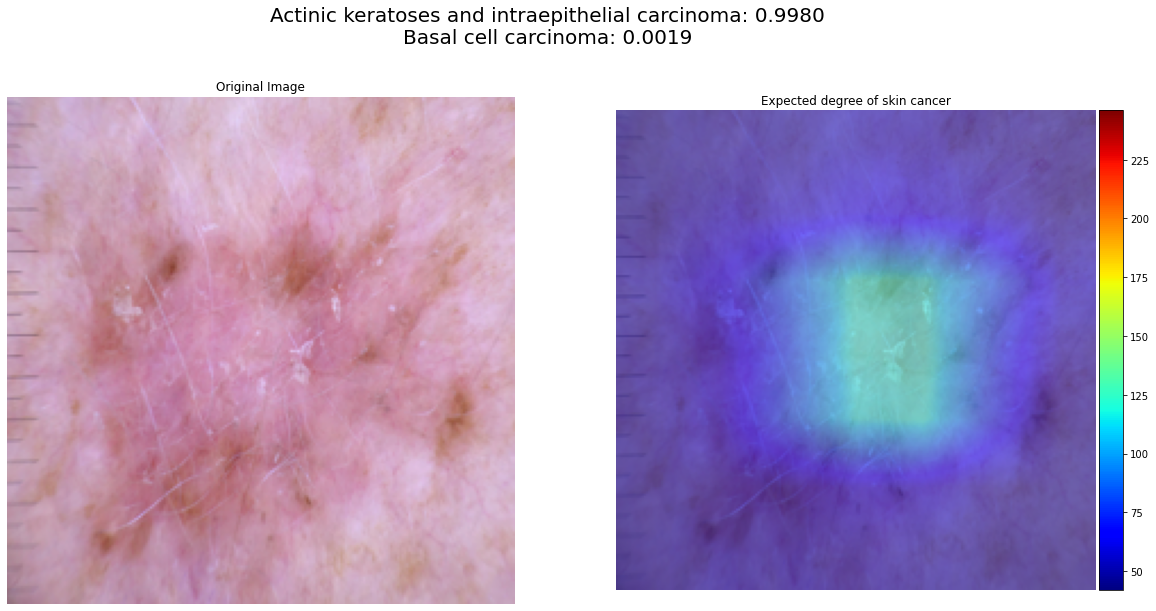

In [4]:
model('./Dataset/Train/ISIC_0026152.jpg')

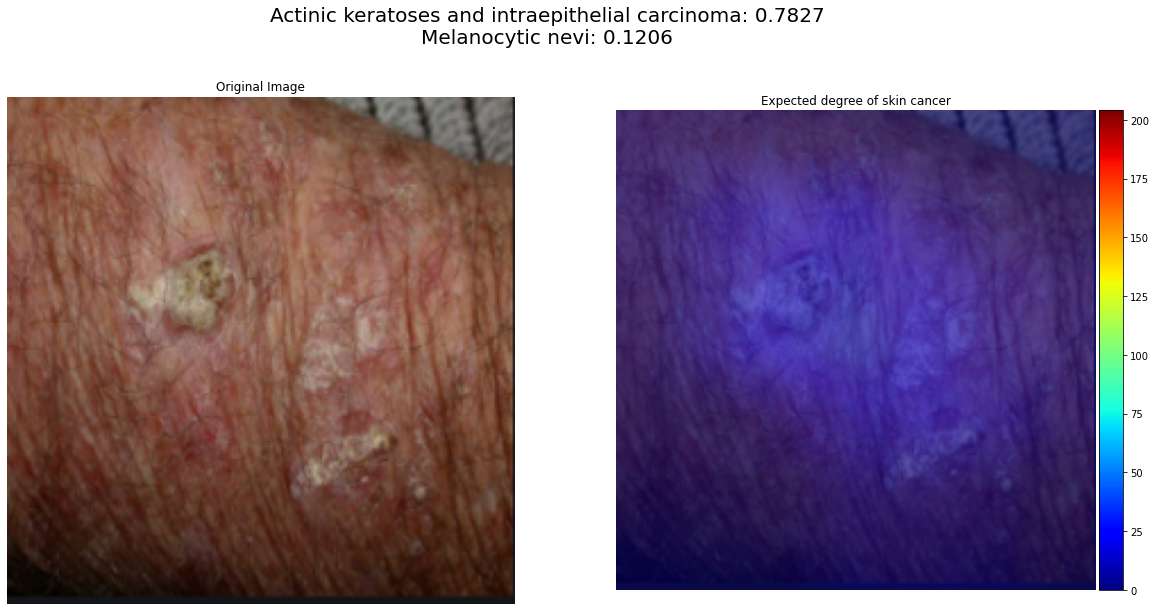

In [5]:
model('./Black_Data/AC_0_1.png', './result2.png')

**Save Final Model**

In [6]:
torch.save(model.state_dict(), './PreTrainModel/final_model.pt')

### Load & Check Result

In [7]:
model = Model()
model.load_state_dict(torch.load('./PreTrainModel/final_model.pt'))

model.eval()

Model(
  (seg_model): ResNetUNet(
    (base_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Bat

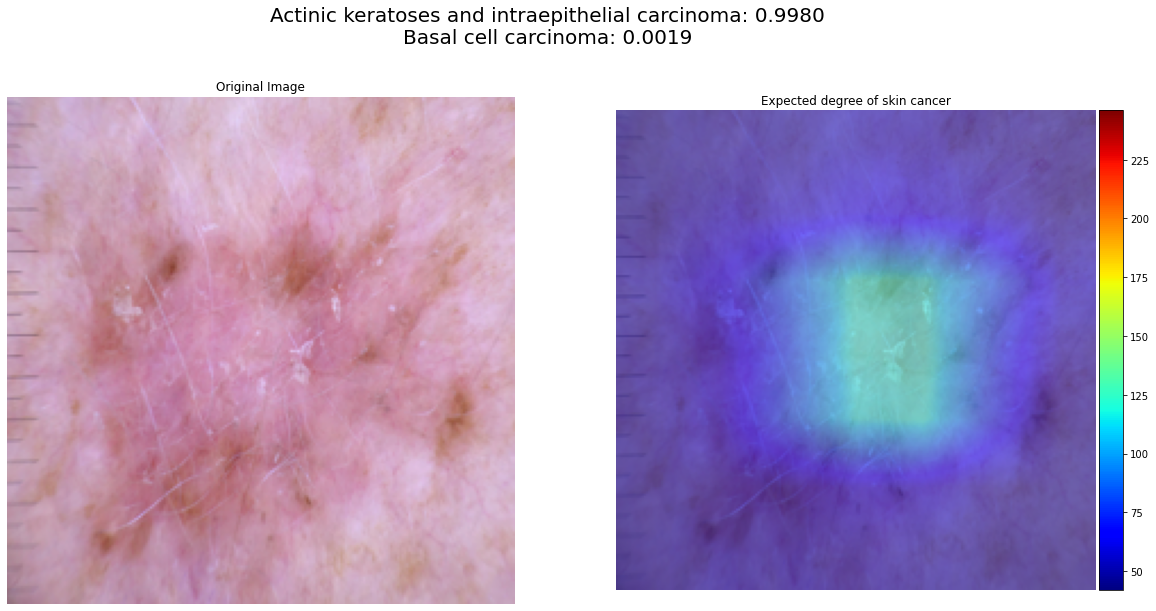

In [8]:
model('./Dataset/Train/ISIC_0026152.jpg')

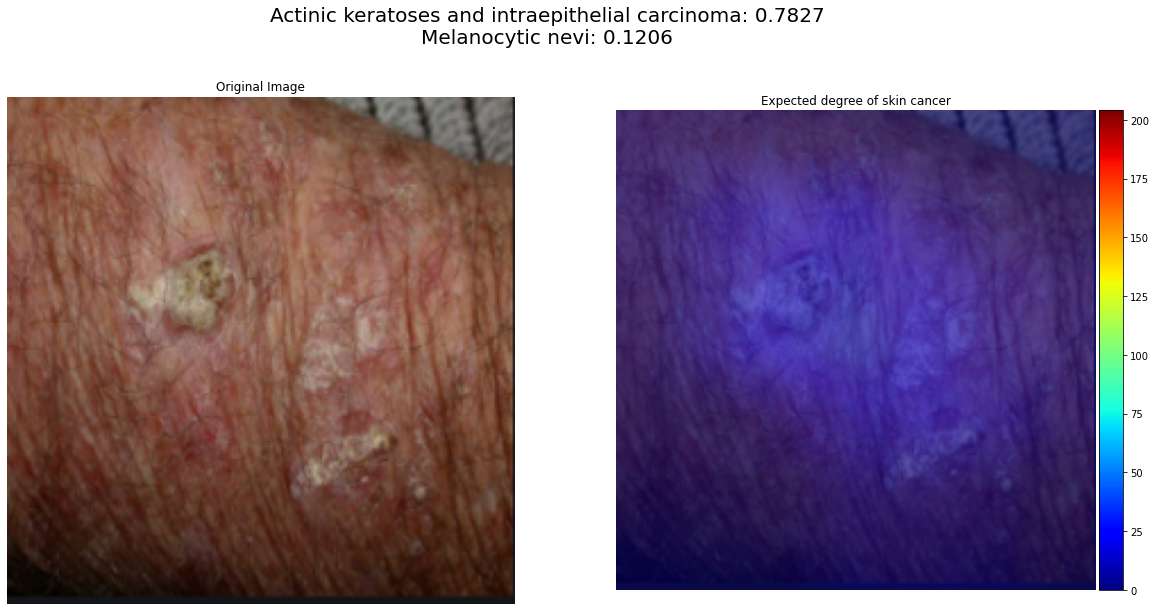

In [9]:
model('./Black_Data/AC_0_1.png', './result3.png')